### Quantum Watermarking

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
from qiskit import *

In [3]:
C_Image = np.zeros([2,2,3]) # (x,y,RGB)

C_Image[0,0,:] = (0,   128, 128)
C_Image[0,1,:] = (128, 0,   128)
C_Image[1,0,:] = (128, 128, 0)
C_Image[1,1,:] = (128, 128, 128)

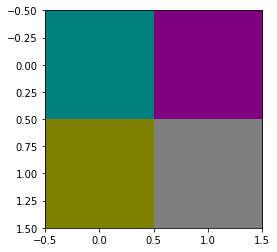

In [4]:
plt.imshow(C_Image/256)
plt.show()

In [5]:
W_Image = np.zeros([2,2,3]) # (x,y,RGB)

W_Image[0,0,:] = (34,   65, 232)
W_Image[0,1,:] = (255, 255,   255)
W_Image[1,0,:] = (228, 128, 54)
W_Image[1,1,:] = (54, 54, 54)

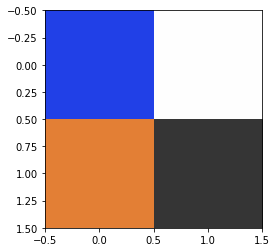

In [6]:
plt.imshow(W_Image/256)
plt.show()

In [7]:
def get_Coeff(Image, watermark=None):
    """ Function that takes in an RGB image matrix of any size and shape and returns qubit coefficients"""
    
    ## build in check sizes Image and watermark are the same
    Flatten_Image = np.reshape(Image, [np.shape(Image)[0]*np.shape(Image)[1],3])
    Theta = (Flatten_Image[:,0]*2**16 + Flatten_Image[:,1]*2**8 + Flatten_Image[:,2])*np.pi/(2**24-1)
    
    if watermark is None:
        Phi = np.zeros(len(Theta))
    else:  
        Flatten_watermark = np.reshape(watermark, [np.shape(watermark)[0]*np.shape(watermark)[1],3])
        Phi = (Flatten_watermark[:,0]*2**16 + Flatten_watermark[:,1]*2**8 + Flatten_watermark[:,2])*np.pi/(2**24-1)

    N = np.ceil(np.log2(np.shape(Image)[0]*np.shape(Image)[1]))/2
    return 1/(2**N)*np.ndarray.flatten(np.transpose(np.stack((np.cos(Theta/2),np.exp(1j*Phi)*np.sin(Theta/2)))))

In [8]:
State_vector = get_Coeff(C_Image)
State_vector

array([0.49999763+0.j, 0.00153997+0.j, 0.35354914+0.j, 0.35355764+0.j,
       0.35246702+0.j, 0.35463643+0.j, 0.35246277+0.j, 0.35464065+0.j])

In [9]:
def initialise_state(desired_initial_state):
    n = int(round(np.log2(desired_initial_state.size)))
    
    # if 2**n != desired_initial_state.size:
        # don't run
    
    qc_init = QuantumCircuit(n)

    qc_init.initialize(desired_initial_state, range(n))
    return qc_init

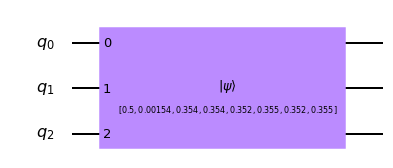

In [10]:
qc_init = initialise_state(State_vector)
qc_init.draw('mpl')

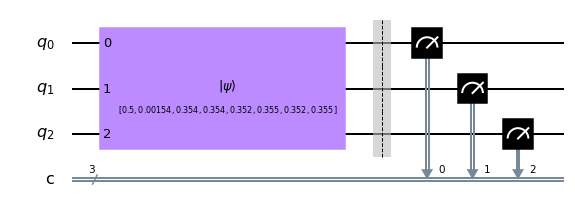

In [11]:
n = int(round(np.log2(State_vector.size)))
shots0 = 1000000

# Create a Quantum Circuit
meas = QuantumCircuit(n, n)
meas.barrier(range(n))
# map the quantum measurement to the classical bits
meas.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc_init + meas

#drawing the circuit
qc.draw('mpl')

In [12]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

{'000': 250573, '001': 4, '010': 124712, '011': 124914, '100': 124171, '101': 125822, '110': 124242, '111': 125562}


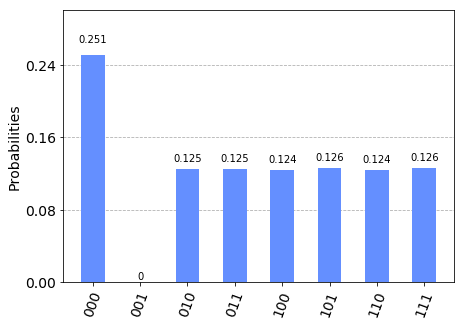

In [13]:
counts = result_sim.get_counts(qc)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [14]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

print(probability_vector)

[2.50573e-01 4.00000e-06 1.24712e-01 1.24914e-01 1.24171e-01 1.25822e-01
 1.24242e-01 1.25562e-01]


In [15]:
p0 = probability_vector[0::2]
p1 = probability_vector[1::2]

In [16]:
def get_RGB(P0):
    """ Function that takes the probablity distribution for the colour qubit 0 """
    Theta = 2*np.arccos(np.sqrt(len(P0)*P0))
    R = np.floor((256*256*256-1)*Theta/(np.pi*256*256))
    G = np.floor(((256*256*256-1)*Theta/(np.pi) - R*256*256)/256) 
    B = np.floor(((256*256*256-1)*Theta/(np.pi) - R*256*256 - G*256))

    return np.stack((R,G,B),axis=1).reshape([np.int(np.sqrt(len(R))),np.int(np.sqrt(len(R))),3])

/home/lcoopmans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arccos
  This is separate from the ipykernel package so we can avoid doing imports until


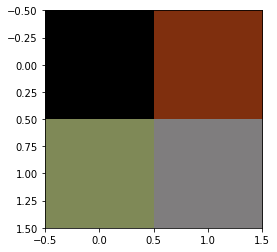

In [18]:
P_Image = get_RGB(p0)
plt.imshow(P_Image/256)

array([0.00615989, 1.57082039, 1.57693234, 1.57695631])

/home/lcoopmans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arccos
  This is separate from the ipykernel package so we can avoid doing imports until


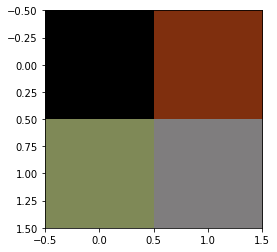

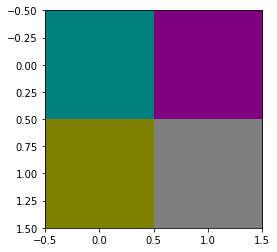